## Import modules and functions

In [ ]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio

## Define directory of images

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Controls/20200315_TNRin_vs_out/' #master folder

## Make dictionary for storing results

In [3]:
results = {"filename":[],"exp":[],"coverslip":[],
           "Manual mask from matlab GUI":[],"bg sub int under mask":[]}
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    #if "analyse" in str(filelist[i]):
        if ("100x" in str(filelist[i]))==False:
            if ("ignore" in str(filelist[i]))==False:
                if ("dditional" in str(filelist[i]))==False:
                    if filelist[i].endswith(".nd2"): 
                        results["filename"].append(filelist[i])
                        results["coverslip"].append(filelist[i].split('/')[-2])
                        results["exp"].append(filelist[i].split('/')[-4])

## Read manual masks from Matlab GUI

In [4]:
## matlab files
for im in range(0,len(results["filename"])): 
    file=results["filename"][im][:-4]+'_dendritesmask.mat'
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        results["Manual mask from matlab GUI"].append(mask)
    else:
        results["Manual mask from matlab GUI"].append(np.nan)
clear_output()        
print("Done!")

Done!


## Batch analysis of images - mean intensity

In [5]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    flag=False
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    with ND2Reader(results["filename"][i]) as images:
        ecm_image=images[0]
    #convert to numpy array - a format easier to manipunuclei with code
    ecm_image=ecm_image.astype(np.int16)
    #read masks 
    matlab_mask=results["Manual mask from matlab GUI"][i]
    if type(matlab_mask)==np.ndarray:
        flag=True
    #image after background subtraction
    #for ecm image
    if flag==True:
        ecm_matlabmasked_bgreduced=deepcopy(ecm_image)
        bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
        ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
        ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
        ecm_matlabmasked_bgreduced[~matlab_mask]=0
        
    if flag==True:
        results["bg sub int under mask"].append(ecm_matlabmasked_bgreduced[matlab_mask].mean())
    else:
        results["bg sub int under mask"].append(np.nan)

Total number of images: 90
Calculating image no 1 out of90
Calculating image no 2 out of90
Calculating image no 3 out of90
Calculating image no 4 out of90
Calculating image no 5 out of90
Calculating image no 6 out of90
Calculating image no 7 out of90
Calculating image no 8 out of90
Calculating image no 9 out of90
Calculating image no 10 out of90
Calculating image no 11 out of90
Calculating image no 12 out of90
Calculating image no 13 out of90
Calculating image no 14 out of90
Calculating image no 15 out of90
Calculating image no 16 out of90
Calculating image no 17 out of90
Calculating image no 18 out of90
Calculating image no 19 out of90
Calculating image no 20 out of90
Calculating image no 21 out of90
Calculating image no 22 out of90
Calculating image no 23 out of90
Calculating image no 24 out of90
Calculating image no 25 out of90
Calculating image no 26 out of90
Calculating image no 27 out of90
Calculating image no 28 out of90
Calculating image no 29 out of90
Calculating image no 30 o

## Make a dataframe of the results

In [6]:
df=pd.DataFrame(results)
df["Condition"]='None'
df.loc[df["filename"].str.contains('All'),"Condition"]="All"
df.loc[df["filename"].str.contains('Surface'),"Condition"]="Surface"
df.loc[df["filename"].str.contains('Inside'),"Condition"]="Inside"

df["Exp"]='None'
df.loc[df["filename"].str.contains('Exp1'),"Exp"]="1"
df.loc[df["filename"].str.contains('Exp2'),"Exp"]="2"
df.loc[df["filename"].str.contains('Exp3'),"Exp"]="3"

df2=df

## Check normality

<class 'numpy.ndarray'>
The variable distributes normally


Text(0.5, 1.0, 'Distribution of all conditions')

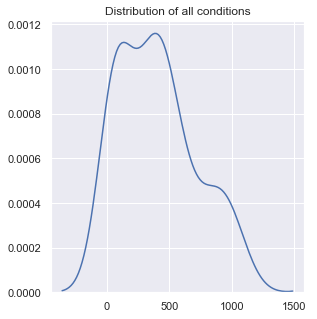

In [7]:
var="bg sub int under mask"
variable=var #change me

x=df2[variable].values
normdvar=(x-x.mean())/x.std()
print(type(normdvar))

import scipy.stats as ss
[_,pval]=ss.kstest(normdvar,'norm')
if pval<0.05:
    print("The variable does not distribute normally")
else:
    print("The variable distributes normally")

sns.set(font_scale=1)
fig=plt.figure(figsize=(10,5))
fig.add_subplot(121)
sns.kdeplot(df2[variable],legend=False)
plt.title('Distribution of all conditions')

    

## Make dataframe of experiment means normd to "all" condition

In [8]:
var="bg sub int under mask"

means={"Exp":[],"Condition":[],
      "intensity normd to all":[]}

df2read=df2
           #& (df2["Exp"]!="20181113_NCAN_analyse")]


for exp in df2read["Exp"].unique():
    dfcalc=df2read[df2read["Exp"]==exp]
    
    means["Exp"].append(exp)
    means["Condition"].append('All')
    dfcalc2=dfcalc[dfcalc["Condition"]=="All"]
    twohour_mean=dfcalc2[var].mean()
    means["intensity normd to all"].append(1)
      
    means["Exp"].append(exp)
    means["Condition"].append('Surface')
    dfcalc2=dfcalc[dfcalc["Condition"]=="Surface"]
    means["intensity normd to all"].append(dfcalc2[var].mean()/twohour_mean)
    
    means["Exp"].append(exp)
    means["Condition"].append('Inside')
    dfcalc2=dfcalc[dfcalc["Condition"]=="Inside"]
    means["intensity normd to all"].append(dfcalc2[var].mean()/twohour_mean)
    
dfmeans=pd.DataFrame(means)

In [9]:
dfmeans

,Exp,Condition,intensity normd to all
0,1,All,1.000000
1,1,Surface,0.114356
2,1,Inside,0.740749
3,2,All,1.000000
4,2,Surface,0.077660
5,2,Inside,0.723170
6,3,All,1.000000
7,3,Surface,0.145030
8,3,Inside,0.819229


## anova

In [10]:
df_all=df2[df2["Condition"]=="All"][var].dropna()
df_surface=df2[df2["Condition"]=="Surface"][var].dropna()
df_inside=df2[df2["Condition"]=="Inside"][var].dropna()




stats.f_oneway(df_all, df_surface, df_inside)

F_onewayResult(statistic=68.60870744336268, pvalue=1.3030802200391226e-18)

## ttests

In [18]:
var="intensity normd to all"
df_all=dfmeans[dfmeans["Condition"]=="All"][var]
df_surface=dfmeans[dfmeans["Condition"]=="Surface"][var]
df_inside=dfmeans[dfmeans["Condition"]=="Inside"][var]

[stat,pval0]=stats.f_oneway(df_all, df_surface, df_inside)

[stat, pval1]=stats.ttest_ind(df_all,df_surface)
[stat, pval2]=stats.ttest_ind(df_surface,df_inside)

print('anova. '+str(pval0))
print('all v surface.  : '+str(pval1*2))
print('surface v inside.   : '+str(pval2*2))


anova. 2.0492836482722393e-07
all v surface.  : 2.770963514461811e-06
surface v inside.   : 0.0001040157858651764


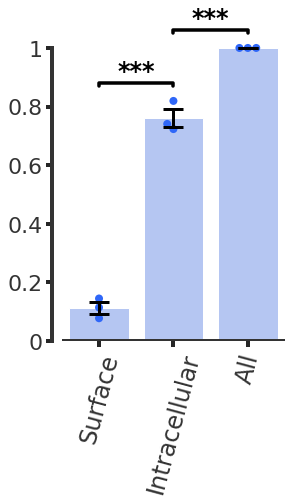

In [76]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker

fig=plt.figure(figsize=(4,6))
df2plot=dfmeans
df2plot=df2plot.reset_index(drop=True)
#var="bg sub int under mask norm2med"
#var="ecm mean int norm2med"
var="intensity normd to all"

order=['Surface',
       'Inside','All'
       ]

paletteswarm ={"Atto647@mouse":"#2F67F8",
               'PFA fixed':"#2F67F8",
               "Methanol fixed":"#2F67F8",
               "chABC - treated":"#2F67F8",
               "No Blocking":"#333333"}
palette ={"Atto647@mouse":"#abc2fc",
               'PFA fixed':"#abc2fc",
               "Methanol fixed":"#abc2fc",
               "chABC - treated":"#abc2fc",
               "No Blocking":"#adadad"}


g=sns.barplot(data=df2plot,y=var,x="Condition",
            order=order,color="#abc2fc",ci=None)

g=sns.swarmplot(data=df2plot,y=var,x="Condition",
            order=order,color="#2F67F8",size=8)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .8)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Condition"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["Condition"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.axhline(0, color='#333333',alpha=1,linewidth=4)

g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)

plt.rcParams['font.sans-serif'] = 'Helvetica'


g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)


g.grid(False)
#plt.ylim([0,600])

for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)

plt.xticks(g.get_xticks(),order,
           rotation=75,size=24)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
plt.yticks([0,.2,.4,.6,.8,1],fontsize=22,color='#333333')
plt.xticks(g.get_xticks(),['Surface','Intracellular','All'],size=24,rotation=75,color='#333333')

scale_x=1
ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}' .format(x/scale_x))
g=plt.gca()
g.yaxis.set_major_formatter(ticks_y)


x1, x2 = 0,1
y= 0.87
h=.01
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')

x1, x2 = 1,2
y= 1.05
h=.01
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')



#for number in range(4):
#    plt.text(number, 230, "***", ha='center', va='bottom', color=col,size=20, weight='bold')





diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

fig.savefig(diri+'supp_tnr_inVout.svg', bbox_inches='tight', format='svg')

In [14]:
df_all.mean()

1.0

In [15]:
df_surface.mean()

0.11234849427351597

In [16]:
df_inside.mean()

0.7610494951899276

In [17]:
df_surface.mean()+df_inside.mean()

0.8733979894634436

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Controls/20200315_TNRin_vs_out/Exp3/Surface/001.nd2
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Controls/20200315_TNRin_vs_out/Exp3/Inside/001.nd2
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Controls/20200315_TNRin_vs_out/Exp3/All/002.nd2


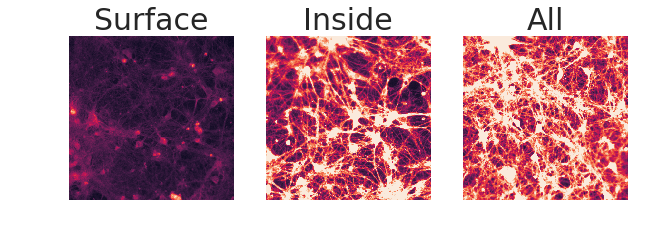

In [69]:
vmin=800
vmax=10000
df2plot=df2
fig=plt.figure(figsize=(10,5))
fig.add_subplot(131)
plt.title('Surface')
df2plotcond=df2plot[df2plot["Condition"]=="Surface"]
df2plotcond=df2plotcond.reset_index()
with ND2Reader(df2plotcond["filename"][20]) as images:
    ecm_imagei=images[0]
plt.imshow(ecm_imagei,vmin=vmin,vmax=vmax)
plt.axis('off')
data = ecm_imagei
im = Image.fromarray(data)
im.save(diri+'surface'+'.tiff')
print(df2plotcond["filename"][20])

fig.add_subplot(132)
plt.title('Inside')
df2plotcond=df2plot[df2plot["Condition"]=="Inside"]
df2plotcond=df2plotcond.reset_index()
with ND2Reader(df2plotcond["filename"][20]) as images:
    ecm_image=images[0]
plt.imshow(ecm_image,vmin=vmin,vmax=vmax)
plt.axis('off')
data = ecm_image
im = Image.fromarray(data)
im.save(diri+'surface'+'.tiff')
print(df2plotcond["filename"][20])

fig.add_subplot(133)
plt.title('All')
df2plotcond=df2plot[df2plot["Condition"]=="All"]
df2plotcond=df2plotcond.reset_index()
with ND2Reader(df2plotcond["filename"][21]) as images:
    ecm_image=images[0]
plt.imshow(ecm_image,vmin=vmin,vmax=vmax)
plt.axis('off')
data = ecm_image
im = Image.fromarray(data)
im.save(diri+'surface'+'.tiff')
print(df2plotcond["filename"][21])

## Number of images in each condition

In [70]:
for condition in df2plot["Condition"].unique():
    print(condition+' ' + 
          str(len(df2plot[df2plot["Condition"]==condition]))+
          '  '+
         str(df2plot[df2plot["Condition"]==condition].mean()))

All 30  bg sub int under mask    637.810934
dtype: float64
Inside 30  bg sub int under mask    494.499168
dtype: float64
Surface 30  bg sub int under mask    76.653393
dtype: float64
